In [1]:
#import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD ,Adam
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Conv2D ,Flatten,Dropout,MaxPool2D, BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception
import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.2)
test_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=(48, 48),
    batch_size=64, color_mode = "grayscale" , class_mode  = "binary"
  )

Found 28709 images belonging to 7 classes.


In [4]:
test_generator  = test_datagen.flow_from_directory(
     '/kaggle/input/fer2013/test',
    target_size=(48, 48),
    batch_size=64 , color_mode = "grayscale" , class_mode  = "binary"
  )

Found 7178 images belonging to 7 classes.


Found 7178 files belonging to 7 classes.


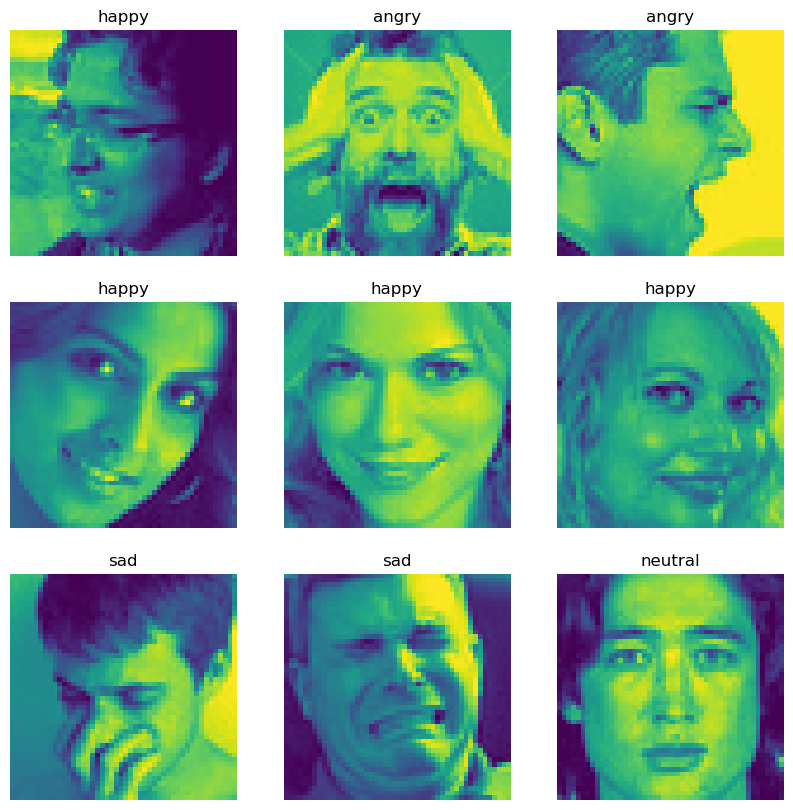

In [5]:
test_dataset = image_dataset_from_directory('/kaggle/input/fer2013/test',
                                             shuffle=True,
                                             batch_size=32,color_mode = "grayscale",image_size=(48,48))
class_name =  test_dataset.class_names
plt.figure(figsize = (10,10))
for image,label  in test_dataset:
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [6]:
#create our model
from keras import regularizers

model =  tf.keras.models.Sequential() 
model.add(Conv2D(32,(3,3), activation='relu' ,input_shape = (48,48,1)))
model.add(Conv2D(64,(3,3),  activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu' , kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

In [8]:
model.compile(optimizer=Adam(lr=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/BEST.h5",
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


In [12]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early , checkpoint,reduce_lr],
    epochs = 100)

/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


2023-08-13 12:41:58.144300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


449/449 [==============================] - ETA: 0s - loss: 4.4087 - accuracy: 0.2516
Epoch 1: val_loss improved from inf to 4.37075, saving model to /kaggle/working/BEST.h5
449/449 [==============================] - 150s 318ms/step - loss: 4.4087 - accuracy: 0.2516 - val_loss: 4.3708 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 3.7594 - accuracy: 0.3015
Epoch 2: val_loss improved from 4.37075 to 3.62295, saving model to /kaggle/working/BEST.h5
449/449 [==============================] - 53s 117ms/step - loss: 3.7594 - accuracy: 0.3015 - val_loss: 3.6230 - val_accuracy: 0.3413 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 3.2945 - accuracy: 0.3324
Epoch 3: val_loss improved from 3.62295 to 3.22941, saving model to /kaggle/working/BEST.h5
449/449 [==============================] - 52s 115ms/step - loss: 3.2945 - accuracy: 0.3324 - val_loss: 3.2294 - val_accuracy: 0.3214 - lr: 1.0000

In [13]:
model.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.2083 - accuracy: 0.5715


[1.208267092704773, 0.5714683532714844]

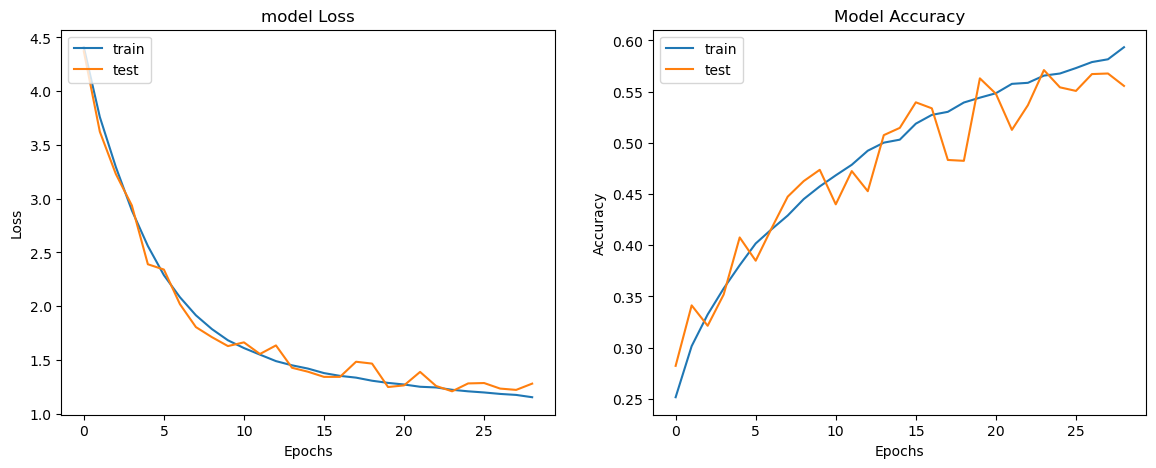

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(FIT.history['accuracy'])
plt.plot(FIT.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(FIT.history['loss'])
plt.plot(FIT.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()